# Data Preparation

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pickle
from sklearn.preprocessing import  StandardScaler
df = pd.read_csv(r"G:\Sem 4\Project\DDoS-attack-detection-using-HTTP-packet-clustering-pattern-master\WP_Dataset\wplogs.csv")
df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14469 entries, 0 to 14468
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   @timestamp           14469 non-null  object 
 1   @timestamp.1         14469 non-null  object 
 2   _id                  14469 non-null  object 
 3   bytes                14469 non-null  object 
 4   clientip             14469 non-null  object 
 5   geoip.country_code3  11535 non-null  object 
 6   httpversion          14453 non-null  float64
 7   request              14453 non-null  object 
 8   response             14469 non-null  int64  
 9   useragent.device     14469 non-null  object 
 10  useragent.name       14469 non-null  object 
 11  useragent.os         14469 non-null  object 
 12  verb                 14453 non-null  object 
 13  useragent.os_name    14469 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 1.5+ MB


# Data Preprocessing

In [5]:
from sklearn.preprocessing import OneHotEncoder

df['@timestamp'] = pd.to_datetime(df['@timestamp'], format='%b %d, %Y @ %H:%M:%S.%f')
df['@timestamp.1'] = pd.to_datetime(df['@timestamp.1'], format='%b %d, %Y @ %H:%M:%S.%f')


df['@timestamp'] = pd.to_datetime(df['@timestamp'])
df['@timestamp.1'] = pd.to_datetime(df['@timestamp.1'])


df['bytes'] = pd.to_numeric(df['bytes'], errors='ignore')


df.dropna(subset=['httpversion', 'request', 'verb'], inplace=True)


df = df[df['clientip'] != '127.0.0.1']


df['geoip.country_code3'].fillna('unknown', inplace=True)


categorical_cols = ['useragent.device', 'useragent.name', 'useragent.os', 'verb', 'useragent.os_name']
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_cols = pd.DataFrame(encoder.fit_transform(df[categorical_cols]))
encoded_cols.columns = encoder.get_feature_names_out(categorical_cols)


df.drop(categorical_cols, axis=1, inplace=True)
df = pd.concat([df, encoded_cols], axis=1)


print(df.head())

TypeError: __init__() got an unexpected keyword argument 'sparse'

# K-means Clustering

C:\Users\Dhina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


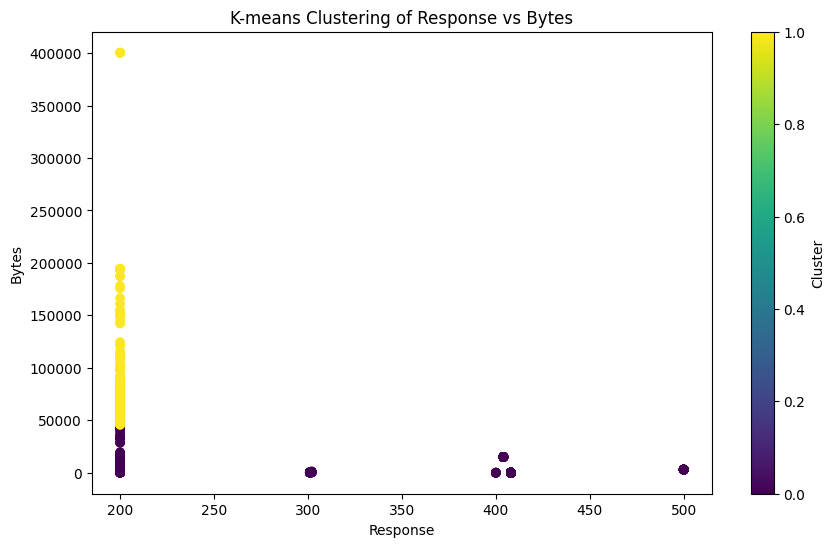

In [17]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


df.dropna(subset=['response', 'bytes'], inplace=True)

df['@timestamp'] = pd.to_datetime(df['@timestamp'])
df['@timestamp.1'] = pd.to_datetime(df['@timestamp.1'])

df['bytes'] = df['bytes'].str.replace(',', '').astype(float)

X = df[['response', 'bytes']]

kmeans = KMeans(n_clusters=2)  
kmeans.fit(X)

df['cluster'] = kmeans.labels_

cluster_0_ips = df[df['cluster'] == 0]['clientip'].unique()

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(df['response'], df['bytes'], c=df['cluster'], cmap='viridis')
plt.title('K-means Clustering of Response vs Bytes')
plt.xlabel('Response')
plt.ylabel('Bytes')
plt.colorbar(label='Cluster')
plt.show()



# Ip-address potenital for Ddos-attack

In [18]:
threshold_per_byte = 1000
timestamp_data = []
distinct_ips = set()

for ip in cluster_0_ips:
    ip_data = df[df['clientip'] == ip]
    for _, row in ip_data.iterrows():
        bytes_transfer = int(row['bytes'])
        if bytes_transfer >= threshold_per_byte:
            timestamp_data.append({
                'clientip': ip,
                '@timestamp': row['@timestamp'],
                'bytes': bytes_transfer
            })
            distinct_ips.add(ip)

ip_frequency = df['clientip'].value_counts()
max_frequency_ips = ip_frequency[ip_frequency == ip_frequency.max()].index

filtered_timestamp_data = []
for data in timestamp_data:
    if data['clientip'] in max_frequency_ips:
        filtered_timestamp_data.append(data)

timestamp_df = pd.DataFrame(filtered_timestamp_data)

print("IP addresses with potential DDoS Attack")
print(list(max_frequency_ips))

print("\nTimestamp Data:")
print(timestamp_df)



IP addresses with potential DDoS Attack
['103.224.146.167']

Timestamp Data:
            clientip          @timestamp   bytes
0    103.224.146.167 2020-06-20 14:45:03   99285
1    103.224.146.167 2020-06-20 14:45:03  194069
2    103.224.146.167 2020-06-20 14:45:03    1248
3    103.224.146.167 2020-06-20 14:45:02    4768
4    103.224.146.167 2020-06-20 14:45:02   15938
..               ...                 ...     ...
271  103.224.146.167 2020-06-20 14:26:29   17307
272  103.224.146.167 2020-06-19 15:40:53    7971
273  103.224.146.167 2020-06-19 15:39:40    7574
274  103.224.146.167 2020-06-19 15:39:30    7971
275  103.224.146.167 2020-06-19 15:38:53    4778

[276 rows x 3 columns]


# Attack phase Visualisation

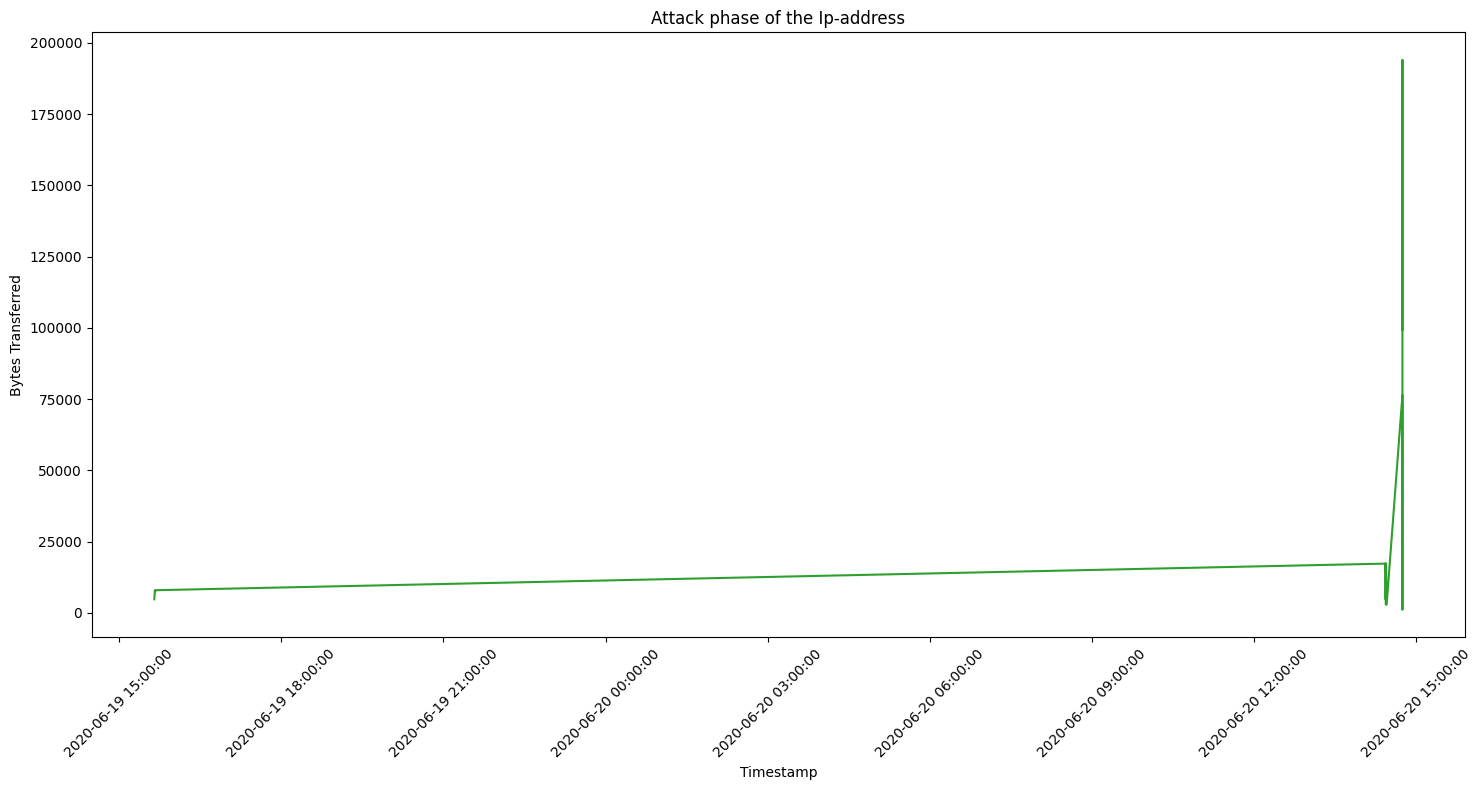

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

timestamp_df['@timestamp'] = pd.to_datetime(timestamp_df['@timestamp'])

fig, ax = plt.subplots(figsize=(15, 8))


for ip in distinct_ips:
    ip_data = timestamp_df[timestamp_df['clientip'] == ip]
    ax.plot(ip_data['@timestamp'], ip_data['bytes'], label=ip)


ax.set_title('Attack phase of the Ip-address')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Bytes Transferred')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Silhoutte_score

In [20]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(X, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)


Silhouette Score: 0.9069786497685776
